# Time Series Forecasting with Transformer in PyTorch
This notebook demonstrates how to use a simple Transformer architecture for time series forecasting using PyTorch.

In [1]:
# Import required libraries
import os
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from data_utils import generate_sine_wave, generate_complex_signal
from transformer_model import RecursiveTimeSeriesTransformer

In [2]:
# Hyperparameters
SEQ_LENGTH = 50
NUM_SAMPLES = 2500
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.001
FORECAST_STEPS = 25

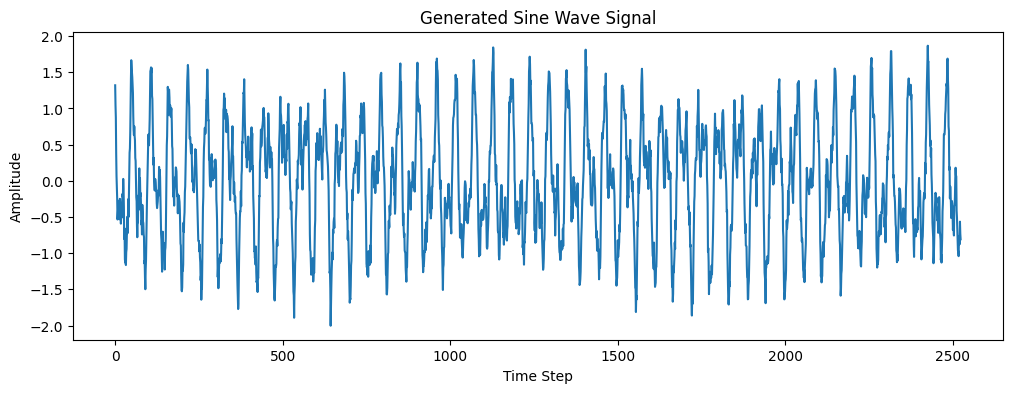

In [3]:
# Generate a single sine wave signal
signal = generate_complex_signal(NUM_SAMPLES + FORECAST_STEPS - 1)  # shape: (NUM_SAMPLES + FORECAST_STEPS - 1,)

plt.figure(figsize=(12, 4))
plt.plot(signal)
plt.title("Generated Sine Wave Signal")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.show()

In [4]:
X = []
y = []
for i in range(len(signal) - SEQ_LENGTH - FORECAST_STEPS + 1):
    X.append(signal[i:i+SEQ_LENGTH])
    y.append(signal[i+SEQ_LENGTH:i+SEQ_LENGTH+FORECAST_STEPS])

X = np.array(X)
y = np.array(y)

In [5]:
# Normalize input and target data using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# After training, inverse transform predictions for evaluation
def inverse_transform_predictions(preds):
    return scaler_y.inverse_transform(preds)

In [6]:
# Train/test split
X_train, y_train = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [7]:
# Convert to tensors and create DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Epoch 1/20, Loss: 0.978257
Epoch 2/20, Loss: 0.252386
Epoch 2/20, Loss: 0.252386
Epoch 3/20, Loss: 0.138866
Epoch 3/20, Loss: 0.138866
Epoch 4/20, Loss: 0.099983
Epoch 4/20, Loss: 0.099983
Epoch 5/20, Loss: 0.080339
Epoch 5/20, Loss: 0.080339
Epoch 6/20, Loss: 0.061276
Epoch 6/20, Loss: 0.061276
Epoch 7/20, Loss: 0.048107
Epoch 7/20, Loss: 0.048107
Epoch 8/20, Loss: 0.042652
Epoch 8/20, Loss: 0.042652
Epoch 9/20, Loss: 0.036073
Epoch 9/20, Loss: 0.036073
Epoch 10/20, Loss: 0.038099
Epoch 10/20, Loss: 0.038099
Epoch 11/20, Loss: 0.032155
Epoch 11/20, Loss: 0.032155
Epoch 12/20, Loss: 0.030317
Epoch 12/20, Loss: 0.030317
Epoch 13/20, Loss: 0.028720
Epoch 13/20, Loss: 0.028720
Epoch 14/20, Loss: 0.028548
Epoch 14/20, Loss: 0.028548
Epoch 15/20, Loss: 0.028741
Epoch 15/20, Loss: 0.028741
Epoch 16/20, Loss: 0.026941
Epoch 16/20, Loss: 0.026941
Epoch 17/20, Loss: 0.026702
Epoch 17/20, Loss: 0.026702
Epoch 18/20, Loss: 0.027213
Epoch 18/20, Loss: 0.027213
Epoch 19/20, Loss: 0.025772
Epoch 19/

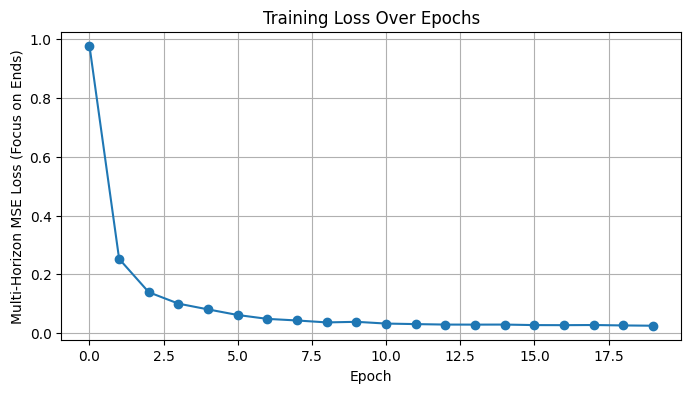

In [8]:
# Initialize the Recursive Transformer model
model = RecursiveTimeSeriesTransformer(seq_length=SEQ_LENGTH, forecast_steps=FORECAST_STEPS).to(device)

# Multi-horizon MSE loss function with custom weights
def multi_horizon_mse_loss(pred, target, weights=None):
    # pred, target: (batch_size, forecast_steps)
    losses = (pred - target) ** 2  # (batch_size, forecast_steps)
    if weights is not None:
        losses = losses * weights
    return losses.mean()

# Create custom weights to focus on both beginning and end
def create_focus_weights(steps):
    # Higher weights at both ends, lower in the middle
    x = np.linspace(-1, 1, steps)
    weights = 1.0 - np.abs(x)  # triangle shape
    weights = 0.5 + weights  # ensure minimum weight is 0.5
    weights = weights / weights.sum() * steps  # normalize to mean 1
    return torch.tensor(weights, dtype=torch.float32).unsqueeze(0)  # shape: (1, steps)

focus_weights = create_focus_weights(FORECAST_STEPS).to(device)

criterion = lambda pred, target: multi_horizon_mse_loss(pred, target, weights=focus_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
train_losses = []
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch}/{EPOCHS}, Loss: {avg_loss:.6f}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Multi-Horizon MSE Loss (Focus on Ends)')
plt.grid(True)
plt.show()

In [9]:
# # Training loop with teacher forcing
# train_losses = []
# for epoch in range(1, EPOCHS + 1):
#     model.train()
#     epoch_loss = 0.0
#     for batch_X, batch_y in train_loader:
#         batch_X = batch_X.to(device)
#         batch_y = batch_y.to(device)
#         optimizer.zero_grad()
#         # Teacher forcing: feed ground truth for each step
#         output = torch.zeros_like(batch_y)
#         prev = batch_X[:, -1]  # last value in input sequence
#         for t in range(FORECAST_STEPS):
#             if t == 0:
#                 inp_seq = batch_X
#             else:
#                 # Concatenate previous ground truth value to sequence
#                 inp_seq = torch.cat([batch_X, batch_y[:, :t]], dim=1)
#                 inp_seq = inp_seq[:, -SEQ_LENGTH:]
#             out_step = model(inp_seq)[:, t].unsqueeze(1)
#             output[:, t] = out_step.squeeze(1)
#         loss = criterion(output, batch_y)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item() * batch_X.size(0)
#     avg_loss = epoch_loss / len(train_loader.dataset)
#     train_losses.append(avg_loss)
#     print(f"Epoch {epoch}/{EPOCHS}, Loss: {avg_loss:.6f}")

# # Plot training loss
# plt.figure(figsize=(8, 4))
# plt.plot(train_losses, marker='o')
# plt.title('Training Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.grid(True)
# plt.show()

Test Loss: 0.030440


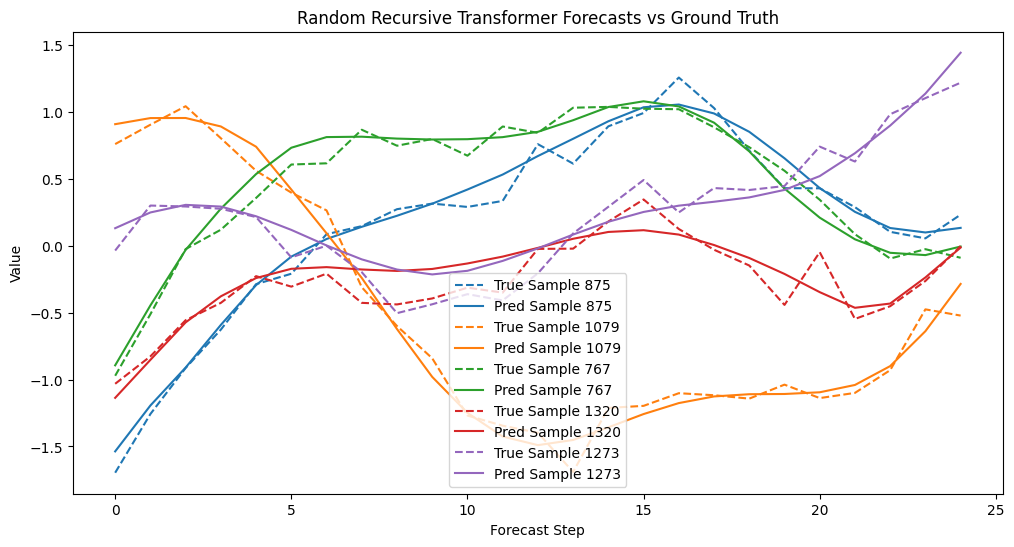

In [12]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
predictions = []
ground_truth = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output = model(batch_X)
        loss = criterion(output, batch_y)
        test_loss += loss.item() * batch_X.size(0)
        predictions.append(output.cpu().numpy())
        ground_truth.append(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {avg_test_loss:.6f}")

# Concatenate all predictions and ground truth
predictions = np.concatenate(predictions, axis=0)
ground_truth = np.concatenate(ground_truth, axis=0)

predictions = inverse_transform_predictions(predictions)
ground_truth = inverse_transform_predictions(ground_truth)

# Choose 5 random indices from the test set
num_samples = min(5, len(predictions))
random_indices = np.random.choice(len(predictions), num_samples, replace=False)

plt.figure(figsize=(12, 6))
for idx, i in enumerate(random_indices):
    plt.plot(range(FORECAST_STEPS), ground_truth[i], label=f'True Sample {i+1}', linestyle='--', color=colors[idx % 10])
    plt.plot(range(FORECAST_STEPS), predictions[i], label=f'Pred Sample {i+1}', color=colors[idx % 10])
plt.title('Random Recursive Transformer Forecasts vs Ground Truth')
plt.xlabel('Forecast Step')
plt.ylabel('Value')
plt.legend()
plt.show()

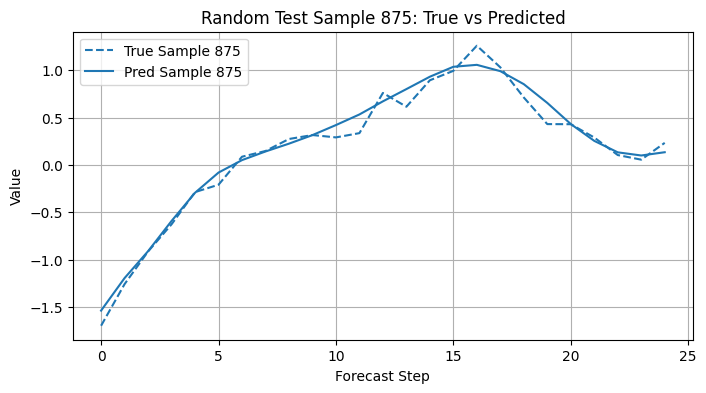

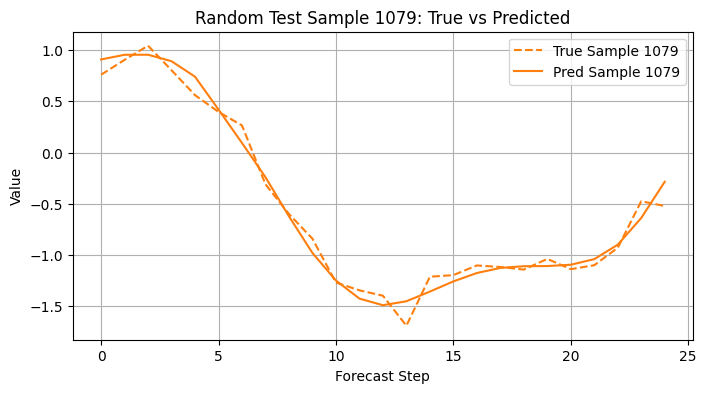

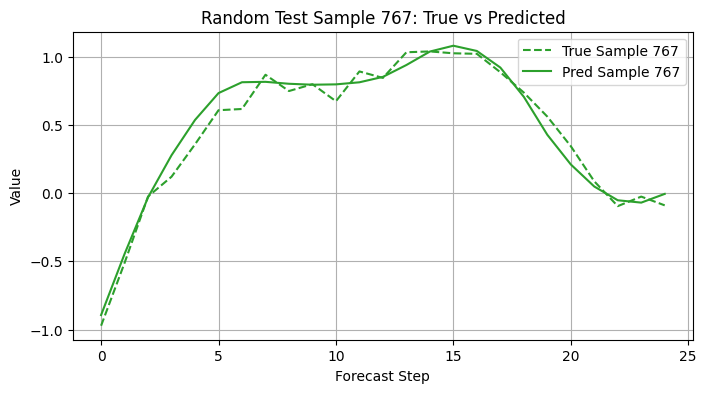

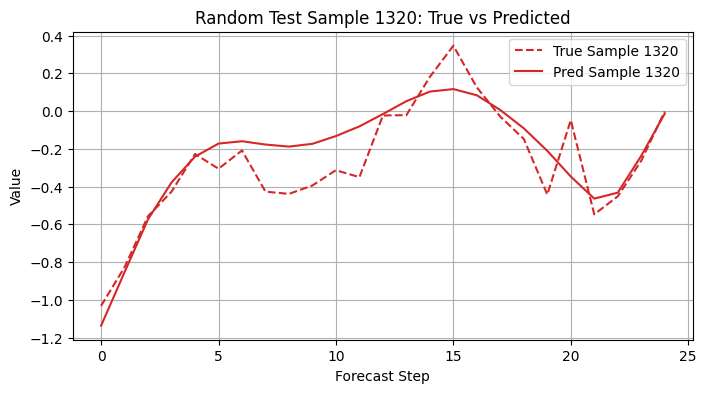

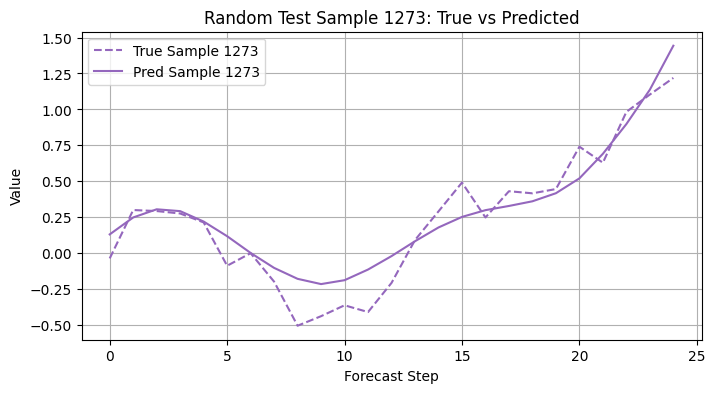

In [17]:
# Plot a separate figure for each true vs predicted sample in the test set (first 5 samples)
# for i in range(min(5, len(predictions))):
#     plt.figure(figsize=(8, 4))
#     plt.plot(range(FORECAST_STEPS), ground_truth[i], label='True', linestyle='--', color='blue')
#     plt.plot(range(FORECAST_STEPS), predictions[i], label='Predicted', color='orange')
#     plt.title(f'Sample {i+1}: True vs Predicted Forecast')
#     plt.xlabel('Forecast Step')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# Plot random samples from the test set
for idx, i in enumerate(random_indices):
    plt.figure(figsize=(8, 4))
    plt.plot(range(FORECAST_STEPS), ground_truth[i], label=f'True Sample {i+1}', linestyle='--', color=colors[idx % len(colors)])
    plt.plot(range(FORECAST_STEPS), predictions[i], label=f'Pred Sample {i+1}', color=colors[idx % len(colors)])
    plt.title(f'Random Test Sample {i+1}: True vs Predicted')
    plt.xlabel('Forecast Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()